# Uplift modelling for Direct Marketing

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylift import TransformedOutcome # pip install pylift
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
plt.style.use('fivethirtyeight')

## The data

In [38]:
df = pd.read_csv("/Users/mingzhangyin/Dropbox (UFL)/UF teaching/My course/11-Causality potential outcome, backdoor adjustment, uplift modeling/EMailAnalytics.csv")
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


The individuals were randomly assigned to three groups; two groups were targeted by two different e-mail campaigns and one group served as control (https://dms.umontreal.ca/~murua/research/UpliftRegression.pdf).
- **Recency**: Months since last purchase.
- **History_Segment**: Categorization of dollars spent in the past year.
- **History**: Actual dollar value spent in the past year.
- **Mens**: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
- **Womens**: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
- **Zip_Code**: Classifies zip code as Urban, Suburban, or Rural.
- **Newbie**: 1/0 indicator, 1 = New customer in the past twelve months.
- **Channel**: Describes the channels the customer purchased from in the past year.

In [39]:
df.visit.value_counts()

0    54606
1     9394
Name: visit, dtype: int64

In [40]:
df.conversion.value_counts()

0    63422
1      578
Name: conversion, dtype: int64

Only 578 customers made purchases, a rather low conversion rate

## Average Treatment Effect of the E-Mail campaign

If the E-Mail campaign is randomized, the average treatment effect (ATE) of the E-Mail campaign for visit rate is:

$$\tau^{p} = \mathbb E[Y(1) - Y(0)] =   P( Y | T=1 ) - P( Y | T=0 ) $$

where $Y \in \{ 0, 1 \} $ is equal to $1$ if the customer visits the website and $0$ otherwise.

In [41]:
def visit_rate_ate(df, test_set=False):
    if test_set:
        treatment_visit_rate = df[df.Treatment == 1].Outcome.mean() * 100
        control_visit_rate = df[df.Treatment == 0].Outcome.mean() * 100
        average_treatment_effect = treatment_visit_rate - control_visit_rate
        print("Test set visit rate uplift: {:.2f}%".format(average_treatment_effect))
        return average_treatment_effect
    else:
        mens = df[df.segment == "Mens E-Mail"].visit.mean() * 100
        womens = df[df.segment == "Womens E-Mail"].visit.mean() * 100
        control = df[df.segment == "No E-Mail"].visit.mean() * 100
        
        print("Men's E-Mail visit rate: {:.2f}%".format(mens))
        print("Women's E-Mail visit rate: {:.2f}%".format(womens))
        print("Control E-mail visit Rate: {:.2f}%".format(control))
        print("---------------------------------")
        print("Men's visit rate uplift: {:.2f}%".format(mens - control))
        print("Women's visit rate uplift: {:.2f}%".format(womens - control))


In [42]:
visit_rate_ate(df)
print()

Men's E-Mail visit rate: 18.28%
Women's E-Mail visit rate: 15.14%
Control E-mail visit Rate: 10.62%
---------------------------------
Men's visit rate uplift: 7.66%
Women's visit rate uplift: 4.52%



## Average spend

$$\mathbb E[\text{spend}] = \mathbb E[\text{spend|purchase}] \times \text{P}(\text{purchase|visit}) \times \text{P}(\text{visit})$$

In [43]:
def spend_given_purchase(df):
    print("Men's average spend given purchase: ${:.2f}".format(
        df[(df.conversion == 1) & (df.segment == 'Mens E-Mail')].spend.mean()))
    print("Women's average spend given purchase: ${:.2f}".format(
        df[(df.conversion == 1) & (df.segment == 'Womens E-Mail')].spend.mean()))
    print("Control average spend given purchase: ${:.2f}".format(
        df[(df.conversion == 1) & (df.segment == 'No E-Mail')].spend.mean()))
    
def purchase_given_visit(df):
    print("Men's purchase rate given visit: {:.2f}%".format(100 * (
            len(df[(df.conversion == 1) & (df.segment == 'Mens E-Mail')]) / len(
        df[(df.visit == 1) & (df.segment == 'Mens E-Mail')]))))
    print("Women's purchase rate given visit: {:.2f}%".format(100 * (
            len(df[(df.conversion == 1) & (df.segment == 'Womens E-Mail')]) / len(
        df[(df.visit == 1) & (df.segment == 'Womens E-Mail')]))))
    print("Control purchase rate given visit: {:.2f}%".format(100 * (
            len(df[(df.conversion == 1) & (df.segment == 'No E-Mail')]) / len(
        df[(df.visit == 1) & (df.segment == 'No E-Mail')]))))

def visit_rate(df):
    print("Men's visit rate: {:.2f}%".format(
        100 * (len(df[(df.visit == 1) & (df.segment == 'Mens E-Mail')]) / len(df[(df.segment == 'Mens E-Mail')]))))
    print("Women's visit rate: {:.2f}%".format(
        100 * (len(df[(df.visit == 1) & (df.segment == 'Womens E-Mail')]) / len(df[(df.segment == 'Womens E-Mail')]))))
    print("Control visit rate: {:.2f}%".format(
        100 * (len(df[(df.visit == 1) & (df.segment == 'No E-Mail')]) / len(df[(df.segment == 'No E-Mail')]))))


def spend_per_head(df):
    print("Men's mean spend: ${:.2f}".format(df[(df.segment == 'Mens E-Mail')].spend.mean()))
    print("Women's mean spend: ${:.2f}".format(df[(df.segment == 'Womens E-Mail')].spend.mean()))
    print("Control mean spend: ${:.2f}".format(df[(df.segment == 'No E-Mail')].spend.mean()))


In [44]:
spend_given_purchase(df)

purchase_given_visit(df)

visit_rate(df)

spend_per_head(df)

Men's average spend given purchase: $113.53
Women's average spend given purchase: $121.89
Control average spend given purchase: $114.00
Men's purchase rate given visit: 6.86%
Women's purchase rate given visit: 5.84%
Control purchase rate given visit: 5.39%
Men's visit rate: 18.28%
Women's visit rate: 15.14%
Control visit rate: 10.62%
Men's mean spend: $1.42
Women's mean spend: $1.08
Control mean spend: $0.65


## Conditional Average Treatment Effect (CATE)

On average there was an uplift in visit rate and expenditure across the population. 

To incorporate the customer heterogeneity, we model the conditional average treatment effect (CATE), i.e. **uplift modelling**. We build a model that identifies subpopulations of customers for which the treatment will have the largest uplift. 

$$ \tau^{(i)} = E[ Y_{i}{(1)} - Y_{i}{(0)}| \mathbf{x}_{i} ] = E( Y_{i} | T=1, \mathbf{x}_{i} ) - E( Y_{i} | T=0, \mathbf{x}_{i} )$$

where the expecation reduces to probabilities for a binary outcome.



## Women's Visit Rate Uplift

In [30]:
womens_df = df[df.segment!='Mens E-Mail'].copy()
womens_df.segment.replace({'Womens E-Mail':1, 'No E-Mail':0}, inplace=True)
womens_df.drop(columns=['conversion', 'spend'], inplace=True)

hist_seg_map = {
    "1) $0 - $100":1,
    "2) $100 - $200":2,
    "3) $200 - $350":3,
    "4) $350 - $500":4,
    "5) $500 - $750":5,
    "6) $750 - $1,000":6,
    "7) $1,000 +":7
}

womens_df.history_segment.replace(hist_seg_map, inplace=True)

# Encode target labels with value between 0 and n_classes-1
zip_code_le, channel_le = LabelEncoder(), LabelEncoder() # LabelEncoder for categorical variables
womens_df.zip_code = zip_code_le.fit_transform(womens_df.zip_code)
womens_df.channel = channel_le.fit_transform(womens_df.channel)
womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)


In [45]:
womens_df.head

<bound method NDFrame.head of        recency  history_segment  history  mens  womens  zip_code  newbie  \
0           10                2   142.44     1       0         1       0   
1            6                3   329.08     1       1         0       1   
2            7                2   180.65     0       1         1       1   
4            2                1    45.34     1       0         2       0   
5            6                2   134.83     0       1         1       0   
...        ...              ...      ...   ...     ...       ...     ...   
63989       10                3   304.30     1       1         1       0   
63990        6                1    80.02     0       1         1       0   
63991        1                3   306.10     1       0         1       1   
63993        4                4   374.07     0       1         1       0   
63998        1                5   552.94     1       0         1       1   

       channel  Treatment  Outcome TransformedOutcome  
0

In [31]:

# using pylift package
up1 = TransformedOutcome(womens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=womens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=18
                        )

up1.fit(n_estimators = 22, min_samples_split = 6079, max_depth = 7, random_state=18)

**Evaluate uplift model**

The model will rank customers by uplift in a descending manner and we will investigate the cumulative uplift of the outcome when targeting increasing proportions of the subpopulation from largest to smallest uplift.

- plot the Qini curve and the uplift barplot
- Qini curve: the x-axis represents the fraction of targeted individuals and the 
- y-axis shows the incremental number of positive responses relative to the total number of targeted individuals.


Test set visit rate uplift: 4.45%
Qini AUC: 0.01333
Qini AUC: 0.00737


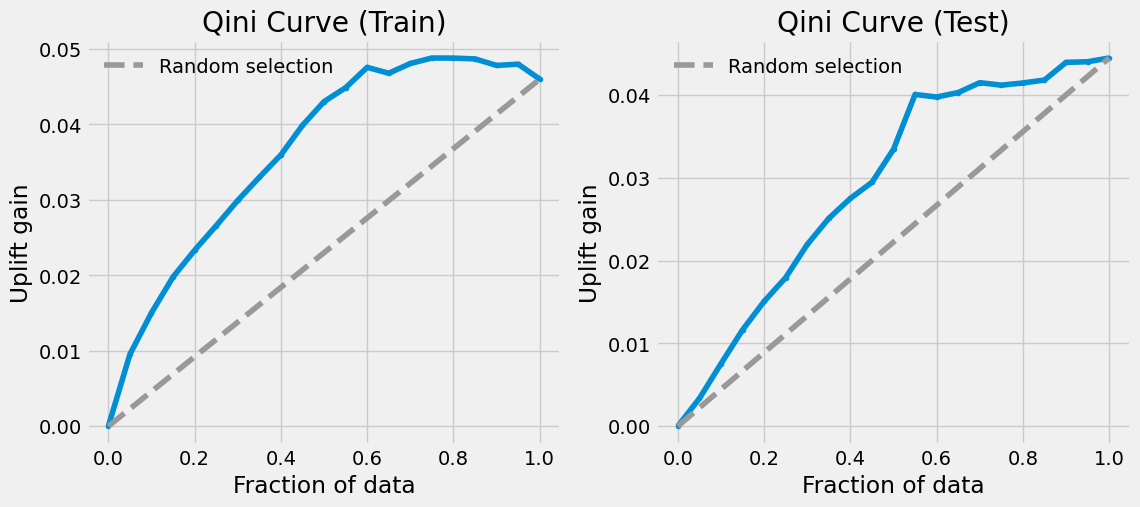

In [13]:
# Plot Train/Test Qini Curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up1.train_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Train)")
ax = fig.add_subplot(122)
up1.test_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Test)")

average_treatment_effect = visit_rate_ate(up1.df_test, test_set=True)
print("Qini AUC: {:.5f}".format(up1.train_results_.Q_qini))
print("Qini AUC: {:.5f}".format(up1.test_results_.Q_qini))

In [14]:
# Test set dataframe containing uplift/response scores scorted into deciles
results_df = up1.df_test.copy()
results_df['uplift'] = up1.transformed_y_test_pred
results_df['uplift_decile'] = pd.qcut(up1.transformed_y_test_pred, 10)

results_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome,TransformedOutcome,uplift,uplift_decile
51797,1,1,81.44,1,0,2,1,1,1,0,0.0,0.002606,"(-0.0939, 0.00261]"
12084,7,1,29.99,1,0,2,1,1,0,0,-0.0,0.001520,"(-0.0939, 0.00261]"
32704,2,2,131.86,0,1,1,0,2,1,0,0.0,0.087292,"(0.0856, 0.0879]"
46254,9,4,458.48,0,1,1,0,1,0,0,-0.0,0.072999,"(0.0662, 0.0752]"
8655,5,2,193.18,0,1,2,0,1,0,0,-0.0,0.075430,"(0.0752, 0.0788]"


In [26]:
results_df['uplift_decile'].value_counts()

(0.00261, 0.00372]    3295
(0.0662, 0.0752]      2341
(-0.0939, 0.00261]    2250
(0.0856, 0.0879]      2196
(0.00567, 0.0137]     2135
(0.0788, 0.0856]      2126
(0.0879, 0.266]       2049
(0.0752, 0.0788]      1936
(0.00372, 0.00567]    1537
(0.0137, 0.0662]      1482
Name: uplift_decile, dtype: int64

**Who to target?**

Target the top X deciles depending on marketing budget etc.

## Understanding customers: average customer features by uplift decile

In [23]:
feats = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
avg_feat_per_decile = results_df.groupby("uplift_decile")[feats[0]].mean().sort_index(ascending=False).reset_index()
for feat in feats[1:]:
    avg_feat_per_decile[feat] = results_df.groupby("uplift_decile")[feat].mean().sort_index(ascending=False).values
avg_feat_per_decile['group'] = ['Group ' + str(num) for num in range(1,11)]
avg_feat_per_decile



,uplift_decile,recency,history_segment,history,mens,womens,zip_code,newbie,channel,group
0,"(0.0879, 0.266]",7.079063,2.585652,275.790073,0.126403,0.989751,0.863348,0.574427,1.348463,Group 1
1,"(0.0856, 0.0879]",6.142532,1.934426,144.700478,0.059654,1.000000,0.763661,0.463115,1.409836,Group 2
2,"(0.0788, 0.0856]",6.484478,1.963311,160.435033,0.113358,1.000000,1.213547,0.438852,1.388993,Group 3
3,"(0.0752, 0.0788]",4.866219,2.603822,240.988889,0.151343,0.993802,1.618285,0.440083,1.320764,Group 4
4,"(0.0662, 0.0752]",4.999146,3.032038,313.653383,0.314823,0.993165,1.537804,0.524135,1.201623,Group 5
5,"(0.0137, 0.0662]",3.330634,4.809042,615.460283,0.614710,0.704453,1.611336,0.688259,0.970310,Group 6
6,"(0.00567, 0.0137]",4.908197,4.048244,455.285433,1.000000,0.000468,1.253396,0.504918,1.047307,Group 7
7,"(0.00372, 0.00567]",4.590761,2.328562,180.935784,1.000000,0.000000,1.275211,0.452180,1.353286,Group 8
8,"(0.00261, 0.00372]",7.438543,1.529894,108.336883,1.000000,0.000000,1.239454,0.478604,1.495599,Group 9
9,"(-0.0939, 0.00261]",6.055556,1.351556,111.713204,0.982667,0.038222,1.258222,0.522222,1.462222,Group 10


Zip code label encodings: ['Rural' 'Surburban' 'Urban']
Channel label encodings: ['Multichannel' 'Phone' 'Web']


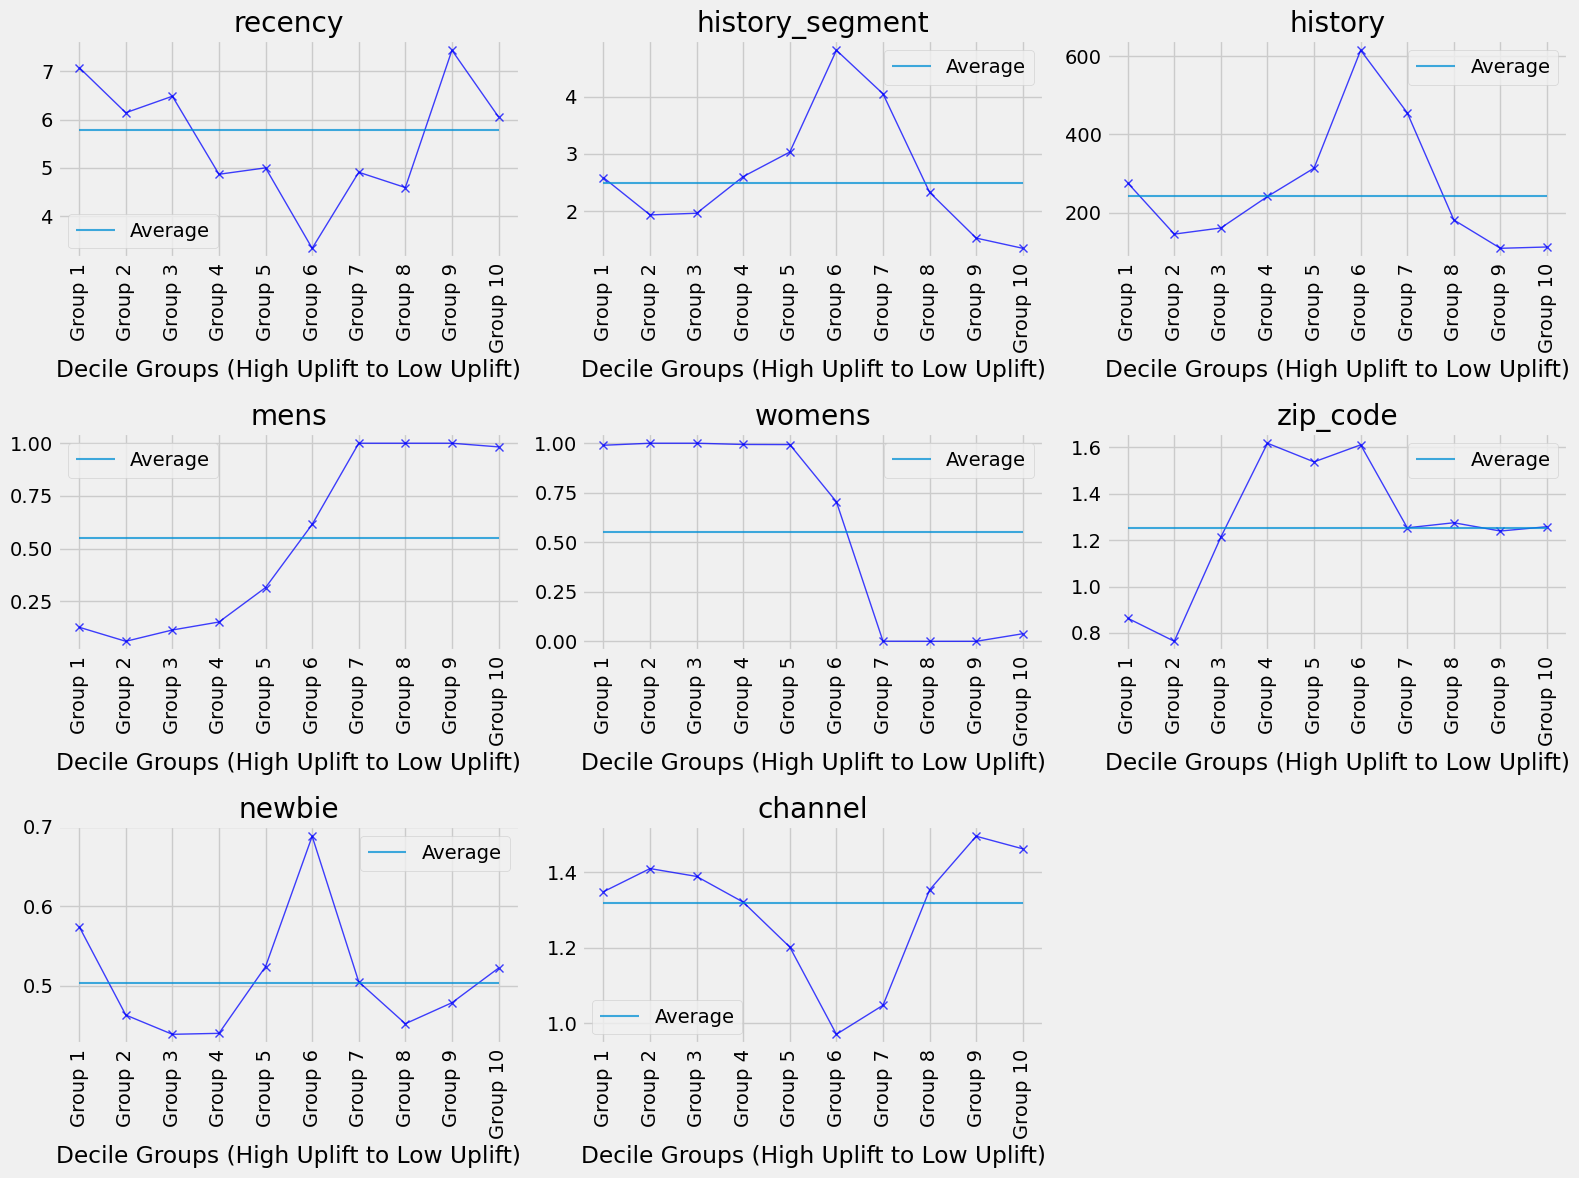

In [27]:

print(f"Zip code label encodings: {zip_code_le.classes_}")
print(f"Channel label encodings: {channel_le.classes_}")

fig = plt.figure(figsize=(16,12))
for idx, feat in enumerate(feats):
    ax = fig.add_subplot(3,3,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(feat)
    ax.plot(avg_feat_per_decile.group, avg_feat_per_decile[feat], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[feat].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout() 

<br>
<br>